In [1]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashplayerstats
base_data = leaguedashplayerstats.LeagueDashPlayerStats(season='2024-25', per_mode_detailed='PerGame')
adv_data = leaguedashplayerstats.LeagueDashPlayerStats(season='2024-25', per_mode_detailed='PerGame', 
                                                       measure_type_detailed_defense='Advanced')


base_df = base_data.get_data_frames()[0]
base_columns= base_df[['PLAYER_ID', 'PLAYER_NAME', 'FGA',
                    'FG3A', 'FTA', 'PTS']]


adv_df = adv_data.get_data_frames()[0]
adv_columns = adv_df[['PLAYER_ID','USG_PCT', 'TS_PCT', 'EFG_PCT','OFF_RATING']]

leaguedash_df = pd.merge(base_columns, adv_columns, on="PLAYER_ID") 
print(leaguedash_df)

#player_row.to_csv('test.csv', index='False')

     PLAYER_ID      PLAYER_NAME   FGA  FG3A  FTA   PTS  USG_PCT  TS_PCT  \
0      1630639      A.J. Lawson   7.3   3.9  2.4   9.1    0.189   0.542   
1      1631260         AJ Green   5.8   5.0  0.4   7.4    0.123   0.621   
2      1642358       AJ Johnson   7.3   3.1  1.3   7.6    0.173   0.480   
3       203932     Aaron Gordon   9.7   3.4  3.5  14.7    0.186   0.650   
4      1628988    Aaron Holiday   4.3   2.9  0.7   5.5    0.162   0.594   
..         ...              ...   ...   ...  ...   ...      ...     ...   
564     203897      Zach LaVine  16.5   7.2  3.9  23.3    0.251   0.639   
565    1630192       Zeke Nnaji   2.5   0.9  0.8   3.2    0.119   0.574   
566    1630533  Ziaire Williams   8.3   4.8  2.0  10.0    0.179   0.550   
567    1629627  Zion Williamson  16.9   0.4  8.0  24.6    0.325   0.600   
568    1642389      Zyon Pullin   0.3   0.0  0.0   0.0    0.167   0.000   

     EFG_PCT  OFF_RATING  
0      0.508       109.7  
1      0.612       114.0  
2      0.441      

In [2]:
#add calculated columns
leaguedash_df['FTA/FGA'] = leaguedash_df['FTA'] / leaguedash_df['FGA'] 
leaguedash_df['PPS'] = leaguedash_df['PTS'] / leaguedash_df['FGA']

print(leaguedash_df.columns)


Index(['PLAYER_ID', 'PLAYER_NAME', 'FGA', 'FG3A', 'FTA', 'PTS', 'USG_PCT',
       'TS_PCT', 'EFG_PCT', 'OFF_RATING', 'FTA/FGA', 'PPS'],
      dtype='object')


In [3]:
from nba_api.stats.endpoints import leaguedashplayershotlocations
import pandas as pd

# Fetch the shot location data
shot_data = leaguedashplayershotlocations.LeagueDashPlayerShotLocations(
    season='2024-25',
    per_mode_detailed='PerGame'
)

df = shot_data.get_data_frames()[0]

# Process and clean the DataFrame
def process_shotlocation_df_clean(df):
    # Flatten multi-index columns if needed
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Dynamically identify PLAYER_ID column
    player_id_col = next(col for col in df.columns if 'PLAYER_ID' in col)

    # Define desired shot zones
    shot_zones = [
        'Restricted Area',
        'In The Paint (Non-RA)',
        'Mid-Range',
        'Left Corner 3',
        'Right Corner 3',
        'Above the Break 3',
        'Backcourt'
    ]
    metrics = ['FGM', 'FGA', 'FG_PCT']

    # Construct target columns
    zone_cols = [f'{zone}_{metric}' for zone in shot_zones for metric in metrics]

    # Build cleaned DataFrame
    cleaned_df = df[[player_id_col] + zone_cols].copy()
    cleaned_df = cleaned_df.rename(columns={player_id_col: 'PLAYER_ID'})

    return cleaned_df

# Run the processor
flat_df = process_shotlocation_df_clean(df)

# Check the output
print(flat_df)


     PLAYER_ID  Restricted Area_FGM  Restricted Area_FGA  \
0      1630639                  1.5                  2.7   
1      1631260                  0.1                  0.2   
2      1642358                  1.6                  2.7   
3       203932                  2.7                  4.2   
4      1628988                  0.3                  0.4   
..         ...                  ...                  ...   
564     203897                  3.2                  4.6   
565    1630192                  0.9                  1.3   
566    1630533                  1.4                  2.4   
567    1629627                  6.1                  9.5   
568    1642389                  0.0                  0.0   

     Restricted Area_FG_PCT  In The Paint (Non-RA)_FGM  \
0                     0.565                        0.3   
1                     0.615                        0.1   
2                     0.570                        0.4   
3                     0.647                    

In [4]:
combined_df = pd.merge(flat_df, leaguedash_df, on="PLAYER_ID") 

final_df = combined_df[combined_df['PTS'] >= 10]

print(final_df)

     PLAYER_ID  Restricted Area_FGM  Restricted Area_FGA  \
3       203932                  2.7                  4.2   
5      1630174                  1.5                  2.2   
6      1630598                  2.2                  3.2   
17     1642259                  1.8                  2.9   
19     1630578                  4.1                  6.3   
..         ...                  ...                  ...   
554    1631117                  4.1                  5.6   
561    1642258                  2.2                  3.5   
564     203897                  3.2                  4.6   
566    1630533                  1.4                  2.4   
567    1629627                  6.1                  9.5   

     Restricted Area_FG_PCT  In The Paint (Non-RA)_FGM  \
3                     0.647                        0.5   
5                     0.680                        0.6   
6                     0.692                        0.6   
17                    0.635                    

In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

player_data = pd.read_csv("final.csv")
player_data.head()

,PLAYER_ID,Restricted Area_FGM,Restricted Area_FGA,Restricted Area_FG_PCT,In The Paint (Non-RA)_FGM,In The Paint (Non-RA)_FGA,In The Paint (Non-RA)_FG_PCT,Mid-Range_FGM,Mid-Range_FGA,Mid-Range_FG_PCT,...,FGA,FG3A,FTA,PTS,USG_PCT,TS_PCT,EFG_PCT,OFF_RATING,FTA/FGA,PPS
0,1628386,4.1,5.3,0.772,1.3,2.3,0.591,0.1,0.2,0.550,...,7.8,0.1,3.4,13.5,0.156,0.724,0.706,121.9,0.435897,1.730769
1,1629655,4.2,5.6,0.743,0.8,1.4,0.543,0.0,0.1,0.667,...,7.1,0.0,3.4,12.3,0.186,0.716,0.702,114.9,0.478873,1.732394
2,1631105,4.1,5.6,0.728,0.8,1.4,0.541,0.0,0.0,1.000,...,7.0,0.0,3.1,11.8,0.161,0.703,0.692,115.5,0.442857,1.685714
3,1631117,4.1,5.6,0.736,0.6,1.1,0.574,0.0,0.0,0.000,...,7.2,0.6,2.6,11.1,0.133,0.660,0.671,109.2,0.361111,1.541667
4,203497,4.5,5.9,0.756,0.3,1.1,0.237,0.0,0.1,0.000,...,7.1,0.0,3.8,12.0,0.129,0.687,0.669,114.3,0.535211,1.690141


In [6]:
#defining input variables
import numpy as np

array = player_data.values
x = np.delete(array, [0, 22], axis=1)

norm = MinMaxScaler().fit(x)
x = norm.transform(x)
print(x)

[[0.4625     0.43809524 0.94827586 ... 0.85140562 0.6284514  0.9976241 ]
 [0.475      0.46666667 0.86494253 ... 0.57028112 0.70255431 1.        ]
 [0.4625     0.46666667 0.82183908 ... 0.59437751 0.64045198 0.93175499]
 ...
 [0.1125     0.15238095 0.36494253 ... 0.26506024 0.17292701 0.03263119]
 [0.175      0.20952381 0.5545977  ... 0.08032129 0.22447603 0.        ]
 [0.2        0.26666667 0.32471264 ... 0.33333333 0.31062076 0.07637614]]


In [7]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=7, random_state=0).fit(x)

In [8]:
kmeans_labels = kmeans.labels_
unique_labels, unique_counts = np.unique(kmeans_labels, return_counts=True)
dict(zip(unique_labels, unique_counts))

{0: 28, 1: 19, 2: 45, 3: 30, 4: 10, 5: 34, 6: 26}

In [9]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

kmeans_cluster_centers = kmeans.cluster_centers_
closest = pairwise_distances_argmin(kmeans.cluster_centers_, x)

player_data.iloc[closest, :]

,PLAYER_ID,Restricted Area_FGM,Restricted Area_FGA,Restricted Area_FG_PCT,In The Paint (Non-RA)_FGM,In The Paint (Non-RA)_FGA,In The Paint (Non-RA)_FG_PCT,Mid-Range_FGM,Mid-Range_FGA,Mid-Range_FG_PCT,...,FGA,FG3A,FTA,PTS,USG_PCT,TS_PCT,EFG_PCT,OFF_RATING,FTA/FGA,PPS
42,1628404,3.2,4.5,0.707,0.6,1.5,0.427,0.3,0.7,0.462,...,10.0,3.3,2.7,13.6,0.151,0.611,0.579,117.9,0.270000,1.360000
121,1628378,2.1,3.5,0.606,1.6,3.4,0.485,1.2,2.8,0.426,...,18.6,8.9,5.1,24.0,0.298,0.575,0.531,119.7,0.274194,1.290323
104,201950,1.5,2.1,0.705,0.6,1.5,0.368,0.3,0.6,0.450,...,9.2,4.9,1.2,11.1,0.156,0.565,0.538,116.6,0.130435,1.206522
165,1630631,0.8,1.4,0.544,0.7,2.0,0.366,0.2,0.4,0.429,...,9.3,5.5,1.3,10.3,0.193,0.523,0.498,108.4,0.139785,1.107527
20,1631109,4.9,6.9,0.712,1.1,3.0,0.377,0.1,0.3,0.545,...,10.2,0.1,3.7,15.3,0.210,0.647,0.604,106.3,0.362745,1.500000
128,203952,1.9,3.2,0.577,1.6,3.4,0.468,0.7,1.6,0.415,...,14.0,5.8,4.3,18.0,0.238,0.566,0.526,109.4,0.307143,1.285714
107,1631114,2.8,4.3,0.663,2.2,4.7,0.462,1.4,3.0,0.459,...,16.9,4.9,4.3,21.6,0.270,0.573,0.537,116.7,0.254438,1.278107


C:\Users\liamj\anaconda3\envs\NeuralNetwork\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


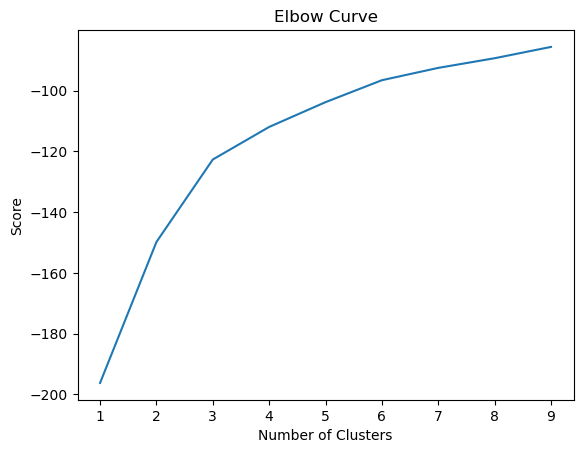

In [10]:
import matplotlib.pyplot as plt

num_cluster = range(1, 10)
kmeans_list = [KMeans(n_clusters=i) for i in num_cluster]
kmeans_list
scores = [kmeans_list[i].fit(x).score(x) for i in range(len(kmeans_list))]
scores
plt.plot(num_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

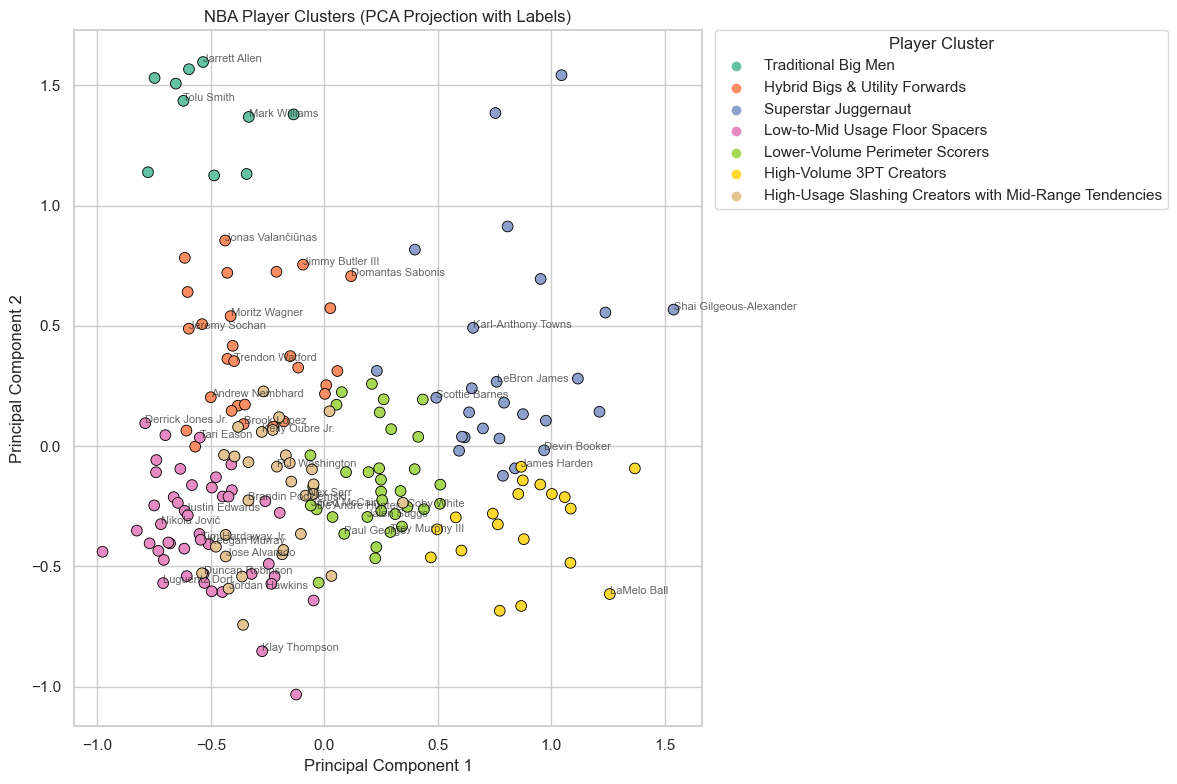

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# STEP 1: Run PCA on your scaled data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)  # x is your already scaled feature matrix

# STEP 2: Prepare plot DataFrame
plot_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
plot_df['Cluster'] = kmeans.labels_
plot_df['PLAYER_NAME'] = player_data['PLAYER_NAME']

# Optional: Add cluster name mapping
cluster_names = {
    0: "Hybrid Bigs & Utility Forwards",
    1: "High-Volume 3PT Creators",
    2: "Low-to-Mid Usage Floor Spacers",
    3: "High-Usage Slashing Creators with Mid-Range Tendencies",
    4: "Traditional Big Men",
    5: "Lower-Volume Perimeter Scorers",
    6: "Superstar Juggernaut"
}
plot_df['Cluster_Name'] = plot_df['Cluster'].map(cluster_names)

# STEP 3: Plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

ax = sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='Cluster_Name',
    palette='Set2',
    s=60,
    edgecolor='black'
)

# Annotate every 5th player for clarity
for i in range(len(plot_df)):
    if i % 5 == 0:
        ax.text(
            plot_df['PC1'][i],
            plot_df['PC2'][i],
            str(plot_df['PLAYER_NAME'][i]),
            fontsize=8,
            alpha=0.7
        )

plt.title("NBA Player Clusters (PCA Projection with Labels)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Move legend outside top-right
plt.legend(
    title="Player Cluster",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=True
)

plt.tight_layout()
plt.show()


In [213]:
cluster_data = player_data.groupby('Cluster').mean(numeric_only=True)

cluster_data.to_csv("clusterinfo.csv", index=True)


In [227]:
for c in sorted(player_data['Cluster'].unique()):
    cluster_df = player_data[player_data['Cluster'] == c]
    filename = f"cluster_{c}.csv"
    try:
        cluster_df.to_csv(filename, index=False)
        print(f"✅ Successfully wrote {filename} with {len(cluster_df)} players.")
    except Exception as e:
        print(f"Failed to write {filename}: {e}")


✅ Successfully wrote cluster_0.csv with 28 players.
✅ Successfully wrote cluster_1.csv with 19 players.
✅ Successfully wrote cluster_2.csv with 45 players.
✅ Successfully wrote cluster_3.csv with 30 players.
✅ Successfully wrote cluster_4.csv with 10 players.
✅ Successfully wrote cluster_5.csv with 34 players.
✅ Successfully wrote cluster_6.csv with 26 players.
